## Importando bibliotecas

In [ ]:
!pip install python-twitter

In [1]:
import twitter
import json

In [2]:
from nltk import word_tokenize
import nltk
import re
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn import svm
from sklearn import metrics
from sklearn.model_selection import cross_val_predict

## Configurando api

In [ ]:
# Carregando o arquivo de configuração
with open('tokens.json') as f:
    data = json.load(f)

In [ ]:
# Carregando a API do Twitter, utilizando os dados do arquivo json
api = twitter.Api(**data)

In [ ]:
# Testa se tudo está certo
# Caso tiver alguma credencial errada, o resultado será:
#twitter.error.TwitterError: [{'code': 32, 'message': 'Could not authenticate you.'}]

print(api.VerifyCredentials())

In [ ]:
# A API do Twitter permite fazer diversos tipos de consultas. 
# Função que, a partir de uma lista de status, mostra o nome do usuário e o texto do twitter.

def print_status(status_list):
    for status in status_list:
        print('(' + str(status.created_at) + ') ' + str(status.user.name) + ':' + str(status.text) + '\n')

## Buscando dados do twitter

In [ ]:
# Busca por termos

status_list = api.GetSearch(term="xiaomi",
                            lang='pt',
                            count=100,
                            result_type='mixed')

## Criando lista com os tweets

In [ ]:
def cria_tweet_list(status_list):
    tweet_list = []
    
    for tweet in status_list:
        tweet_list.append(tweet.text)
    
    return tweet_list

In [ ]:
# Printando elementos
print_status(status_list)

In [ ]:
print(len(status_list))

In [ ]:
tweet_list = cria_tweet_list(status_list)

In [ ]:
print(tweet_list)

## Coloca os tweets da lista em um arquivo .csv

In [ ]:
def cria_arquivo_csv(lista):
    arquivo = open('xiaomi.csv', 'w', encoding='utf-8')
    
    for pos_tweet in range(len(lista)):
        arquivo.write('"' + str(lista[pos_tweet]) + '"')
        arquivo.write('\n')
        
    arquivo.close()

In [ ]:
cria_arquivo_csv(tweet_list)

## Cria um data frame (depois dos dados extraidos)

In [3]:
# Criando data frame
df = pd.read_csv('classificado_xiaomi.csv', encoding='utf-8')

In [4]:
df.head()

,tweets,classes
0,Agr até eu quero um xiaomi,positivo
1,xiaomi= tudo pra mim. https://t.co/7lAvXTxa2J,positivo
2,RT @karnsteins: meu celular está 1 dia e 6 hor...,positivo
3,@Juliano_Fleck Se procura aplicativo usa o Sma...,positivo
4,@paginamemebro nn gosto da câmera do xiaomi,negativo


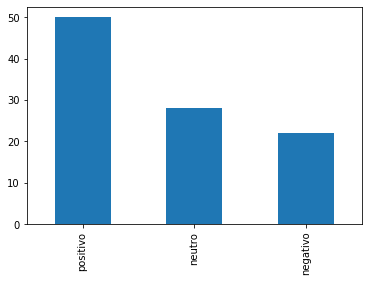

In [5]:
%matplotlib inline
df.classes.value_counts().plot(kind='bar')

In [6]:
df.classes.value_counts()

positivo    50
neutro      28
negativo    22
Name: classes, dtype: int64

In [7]:
df.tweets.count()

100

## Remove os tweets duplicados

In [8]:
df.drop_duplicates(inplace=True)

In [9]:
df.tweets.count()

99

In [10]:
tweets = df['tweets']
classes = df['classes']

In [11]:
print(len(tweets))
print(len(classes))

99
99


## Limpeza dos dados

In [12]:
# Para limpeza dos dados
import nltk
nltk.download('stopwords')
nltk.download('rslp')
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\MaluF\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package rslp to
[nltk_data]     C:\Users\MaluF\AppData\Roaming\nltk_data...
[nltk_data]   Package rslp is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\MaluF\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\MaluF\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [13]:
stopwords = set(nltk.corpus.stopwords.words('portuguese'))
print(stopwords)

{'tenhamos', 'aquela', 'sem', 'formos', 'terá', 'estiverem', 'pelas', 'fui', 'houve', 'não', 'das', 'pela', 'estes', 'estiver', 'terei', 'somos', 'à', 'hei', 'por', 'suas', 'lhes', 'também', 'do', 'eu', 'está', 'ela', 'houveram', 'foi', 'meu', 'foram', 'tenho', 'os', 'estas', 'seriam', 'tinha', 'tivermos', 'sou', 'nosso', 'estão', 'vos', 'houvemos', 'eles', 'qual', 'tive', 'minha', 'dele', 'esta', 'depois', 'houvessem', 'essas', 'e', 'houvéssemos', 'houveríamos', 'serão', 'deles', 'que', 'para', 'aqueles', 'tu', 'esteja', 'serei', 'seremos', 'tiveram', 'tivessem', 'tínhamos', 'ou', 'numa', 'teríamos', 'havemos', 'às', 'fomos', 'minhas', 'estava', 'estávamos', 'éramos', 'tivéssemos', 'num', 'terão', 'nossos', 'tenha', 'a', 'seus', 'me', 'uma', 'seria', 'fôssemos', 'só', 'estiveram', 'estivemos', 'temos', 'ao', 'há', 'é', 'tivesse', 'nossa', 'já', 'em', 'se', 'te', 'nós', 'tinham', 'este', 'elas', 'tuas', 'esteve', 'com', 'houverão', 'tua', 'esses', 'dos', 'houverem', 'de', 'eram', 'tém'

In [14]:
def Preprocessing(instancia):
    stemmer = nltk.stem.RSLPStemmer()
    instancia = re.sub(r"http\S+", "", instancia).lower().replace('.','').replace(',','').replace(';','').replace('-','').replace(':','').replace(')','')
    stopwords = set(nltk.corpus.stopwords.words('portuguese'))
    stopwords.remove('não')
    palavras = [stemmer.stem(i) for i in instancia.split() if not i in stopwords]
    return (" ".join(palavras))

In [15]:
testes = [Preprocessing(i) for i in tweets]

## Tokenização

In [16]:
from nltk.tokenize import TweetTokenizer

In [17]:
tweet_tokenizer = TweetTokenizer()

## Vetorização - Bag of words

In [18]:
# Instancia o objeto que faz a vectorização
vectorizer = CountVectorizer(analyzer="word", tokenizer=tweet_tokenizer.tokenize)

In [19]:
# Aplica o vetorizador nos dados
# Ajuste o modelo SVM de acordo com os dados de treinamento fornecidos.
freq_tweets = vectorizer.fit_transform(testes)
type(freq_tweets)

scipy.sparse.csr.csr_matrix

In [20]:
print(len(testes))

99


In [21]:
# Formato linha, coluna da matriz
freq_tweets.shape

(99, 444)

## Treinando o modelo

In [22]:
modelo = svm.SVC(gamma='auto')

In [23]:
modelo.fit(freq_tweets,classes)
#passando os tweets vetorizados (x, y) e as classes
#mostrando pro modelo como ele aprender como ele representa os sentimentos

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

## Matriz

In [24]:
freq_tweets.A

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 1]], dtype=int64)

## Criando modelos com Pipelines

In [25]:
# Pipelines são interessantes para reduzir código e automatizar fluxos
from sklearn.pipeline import Pipeline

In [26]:
pipeline_svm_simples = Pipeline([
  ('counts', CountVectorizer()),
  ('classifier', svm.SVC(kernel='linear'))
])

## Validando os Modelos com Validação Cruzada

In [27]:
# Fazendo o cross validation do modelo
resultados = cross_val_predict(pipeline_svm_simples, testes, classes, cv=48)

c:\users\maluf\appdata\local\programs\python\python37-32\lib\site-packages\sklearn\model_selection\_split.py:657: Warning: The least populated class in y has only 22 members, which is too few. The minimum number of members in any class cannot be less than n_splits=48.
  % (min_groups, self.n_splits)), Warning)


In [28]:
# Matriz de confusão
print(pd.crosstab(classes, resultados, rownames=['Real'], colnames=['Predito'], margins=True))

Predito   negativo  neutro  positivo  All
Real                                     
negativo         7       3        12   22
neutro           3      11        14   28
positivo         2       4        43   49
All             12      18        69   99


In [29]:
# Medindo a acurácia média do modelo
metrics.accuracy_score(classes,resultados)

0.6161616161616161

In [30]:
acuracia = (7+11+43)/99
print('acuracia = ', acuracia)

acuracia =  0.6161616161616161


In [31]:
# Medidas de validação do modelo
sentimento=['positivo','negativo','neutro']
print (metrics.classification_report(classes,resultados,sentimento))

              precision    recall  f1-score   support

    positivo       0.62      0.88      0.73        49
    negativo       0.58      0.32      0.41        22
      neutro       0.61      0.39      0.48        28

    accuracy                           0.62        99
   macro avg       0.61      0.53      0.54        99
weighted avg       0.61      0.62      0.59        99

